# GeoSIR Reliability Analysis

## Understanding $R_0$ - "R naught"

**Definition:**  
$R_0$ (pronounced "R naught") is the *basic reproduction number*: The expected number of new infections directly generated by one infectious individual in a fully susceptible population.

**Interpretation:**
- $R_0 > 1$: the infection spreads (epidemic growth)  
- $R_0 = 1$: stable (each case replaces itself)  
- $R_0 < 1$: the infection dies out  

**Formula (simplified):**  
$$
R_0 = \beta \times D
$$
where  
- $\beta$ = transmission rate per contact  
- $D$ = duration of infectiousness  

**Intuition:**  
Think of $R_0$ as how "social" a pathogen is in a naive population; a higher $R_0$ means more contagious.

## What is a reliability analysis?

This tutorial will cover the application of a simple reliability analysis on [GeoSIR](https://mesa-geo.readthedocs.io/latest/examples/geo_sir.html). The purpose of which is to demonstrate how one can apply calibration procedures to analyse and refine individual mechanistic processes within a simulation model.

The primary aim of a reliability analysis is to compute the probability of any event under uncertainty defined by a threshold or condition:

$$
E = \{ \mathbf{X} \mid g(\mathbf{X}) \le 0 \}
$$

**Examples**

- **Exceeding a threshold:**  
  $g(X) = X_1 + X_2 - 5 → P(X_1 + X_2 > 5)$

- **Inside a safe zone:**  
  $g(X) = X_1^2 + X_2^2 - 1 → P(X_1^2 + X_2^2 \le 1)$

- **Any custom condition:**  
  Define $g(X)$ however you like. calisim just finds the probability that $g(X) \le 0$.

Secondary purposes include:

- **Sensitivity analysis:**  
  Find which inputs most influence reliability (via FORM importance factors).

- **Design optimization:**  
  Adjust parameters to meet a target failure probability.

- **Risk assessment:**  
  Handle multiple failure modes or safety thresholds.

- **Efficient simulation:**  
  Use FORM, importance sampling, or subset simulation  
  to focus on rare or critical events.

## Running GeoSIR

It is possible to run GeoSIR from a [Solara dashboard](https://solara.dev/) to get an idea of what our agent-based simulation model looks like.

In [20]:
! solara run geosir_network_app.py --host 0.0.0.0 --port 8765

New version of Solara available: 1.52.0. You have 1.49.0. Please upgrade using:
	$ pip install "solara==1.52.0"
Solara server is starting at http://0.0.0.0:8765
^C


# Imports

We will first import all required dependencies and specify our constants.

In [1]:
from geosir_network import GeoSir
from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.reliability import (
	ReliabilityAnalysisMethod,
	ReliabilityAnalysisMethodModel,
)
import numpy as np

N_DAYS = 30
POP_SIZE = 250
NETWORK_GRID_TYPE = 1

# Calibration procedure

## Reliability Analysis

We will next run the reliability analysis. For this exercise, there are three parameters of interest within GeoSIR: 

- **INIT_INFECTED**: The proportion of initial infected within the population.
- **EXPOSURE_DISTANCE**: The distance required between agents for the transmission of an infection to potentially occur.
- **INFECTION_RISK**:  The probability of infection occurrence upon contact between agents.

Let's use a reliability analysis to evaluate how these three parameters impact the estimate of $R_0$. We will compute $R_0$ using the median consensus estimate between two different methods. Firstly, $R_0$ can be calculated directly, as we're modelling transmissions at the individual-level. Secondly, we will use the proxy contact tracing method, as described in [Estimating the reproduction number, R0, from individual-based models of tree disease spread (Wadkin et al., 2024)](https://www.sciencedirect.com/science/article/pii/S030438002400019X)

We will first specify our parameter distributions:

In [17]:
parameter_spec = ParameterSpecification(
    parameters=[
        DistributionModel(
            name="init_infected",
            distribution_name="uniform",
            distribution_args=[0.05, 0.2],
			data_type=ParameterDataType.CONTINUOUS,
        ),
        DistributionModel(
            name="exposure_distance",
            distribution_name="uniform",
            distribution_args=[50, 200],
			data_type=ParameterDataType.CONTINUOUS,
        ),
        DistributionModel(
            name="infection_risk",
            distribution_name="uniform",
            distribution_args=[0.05, 0.2],
			data_type=ParameterDataType.CONTINUOUS,
        )
    ]
)

We will next define our reliability analysis function. We will run the GeoSIR simulation for 30 days with 250 agents, and subsequently extract the end-of-simulation median consensus estimate of $R_0$ produced by the model.

In [18]:
def reliability_func(
    parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    model = GeoSir(
        pop_size=POP_SIZE, 
        init_infected=parameters["init_infected"], 
        exposure_distance=parameters["exposure_distance"], 
        infection_risk=parameters["infection_risk"],
        network_grid_type = NETWORK_GRID_TYPE
    )
    model.run(N_DAYS)
    
    state_df = model.get_states_df()
    end_state = state_df.tail(1)
    r_0 = np.median(end_state[["contact_r_0t", "proxy_contact_r0"]].values)
    
    return r_0

We will next run the reliability analysis using the Sobol method. Of our many GeoSIR runs, what is the probability that the estimate of $R_0$ will be greater or equal to 1?

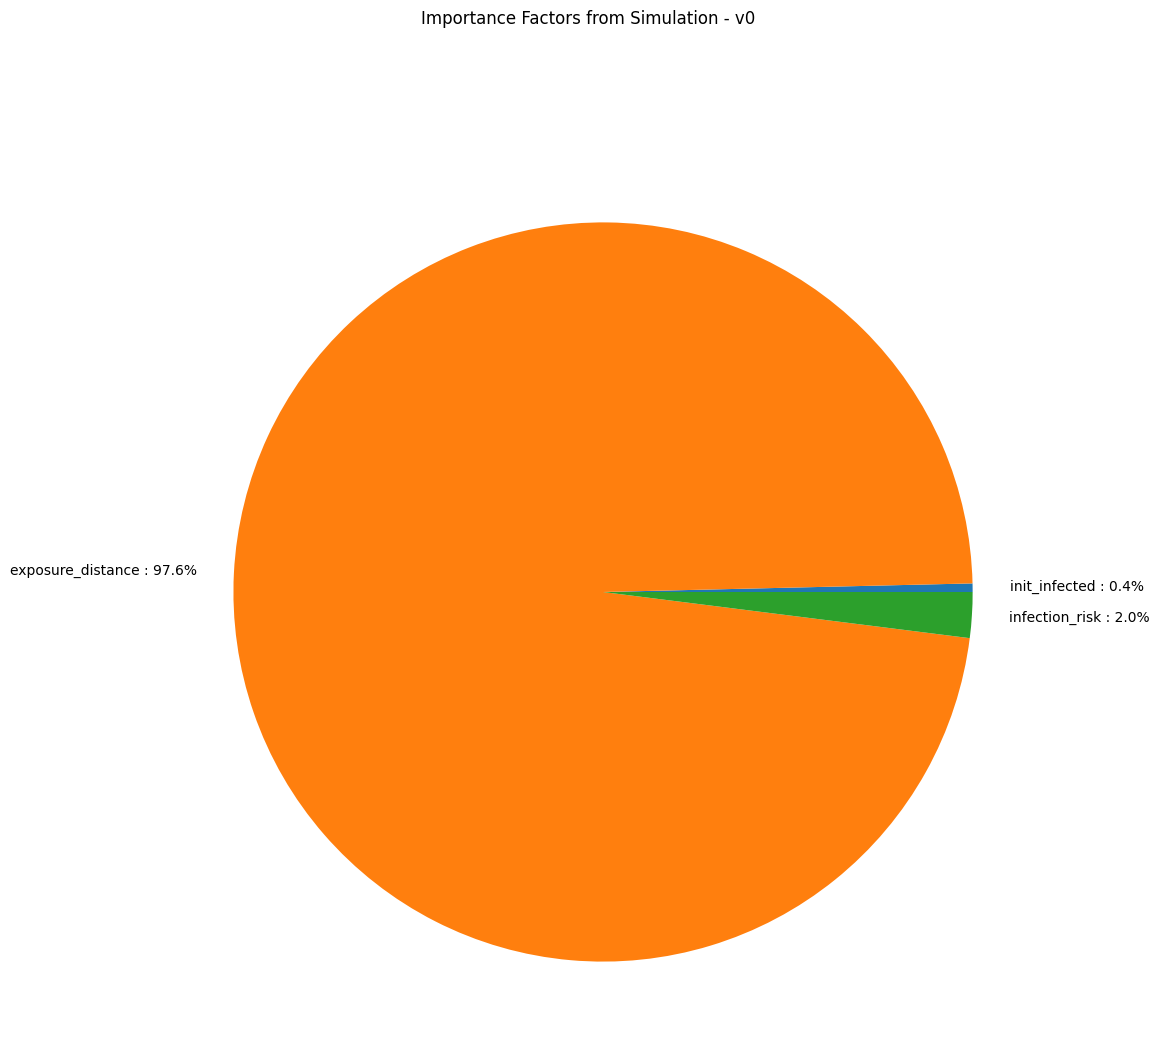

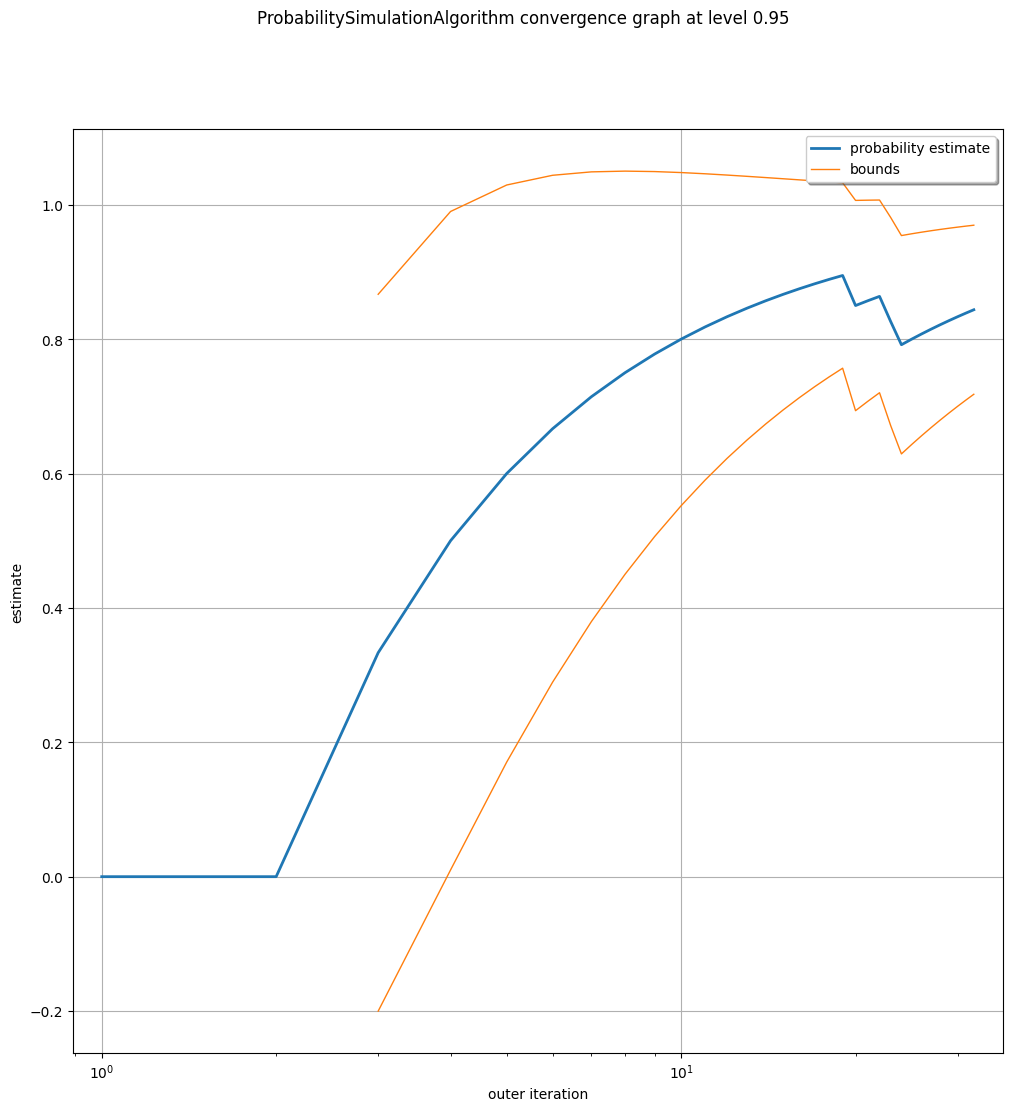

In [23]:
specification = ReliabilityAnalysisMethodModel(
    experiment_name="openturns_reliability_analysis",
    parameter_spec=parameter_spec,
    method="sobol",
	n_samples=30,
	comparison="greater_or_equal",
	threshold=1,
    output_labels=["Median consensus R-Naught"],
)

calibrator = ReliabilityAnalysisMethod(
    calibration_func=reliability_func, specification=specification, engine="openturns"
)

calibrator.specify().execute().analyze()

In [25]:
calibrator.implementation.sampler.getResult()

probabilityEstimate=8.437500e-01 varianceEstimate=4.119873e-03 standard deviation=6.42e-02 coefficient of variation=7.61e-02 confidenceLength(0.95)=2.52e-01 outerSampling=32 blockSize=1

According to these results, the exposure distance is most influential in determnining whether the $R_0$ estimate will be greater or equal to 1.

Noting that our results are stochastic (and that the number of samples is fairly small), according to these results there is roughly an 80% probability that the $R_0$ estimate will be greater or equal to 1.

A future exercise for the interested reader would be to execute more samples for the reliability analysis. In reality, you would want to run several thousands to tens of thousands of simulations, particularly as agent-based models are stochastic and tend to be quite noisy.